# Wykorzystanie głebokich konwolucyjnych do klasyfikacji cech twarzy ze zbioru CelebA

<img src="https://pbs.twimg.com/media/Cxf17XAUAAAnGX9.jpg",width=800>
<img src="http://mmlab.ie.cuhk.edu.hk/projects/celeba/intro.png",width=800>

http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html

## Zaimportowanie bibliotek

In [1]:
#operacje związane ze ścieżkami
import os
from glob import glob

#operacje na macierzach
import numpy as np

#operacje na danych tabelarycznych
import pandas as pd

#operacje na obrazach
from PIL import Image

#miła dla oka wizualizacja postępu i nie tylko
from tqdm import tqdm

#tworzenie wykresów i wizualizacja danych
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm

#funkcja ułatwiająca podział zbioru danych na treningowy i testowy
from sklearn.model_selection import train_test_split

#weryfikacj jakości predykcji
from sklearn.metrics import classification_report

#importy z biblioteki keras, umożlkiwiające krótszy zapis implementacji
from keras.layers import Dense, Input, Dropout
from keras.layers import Conv2D, Flatten, MaxPooling2D
from keras.models import Model
from keras.utils import plot_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import activations

#wizualizacja map aktywacji klas (CAM)
from vis.visualization import visualize_cam, overlay
from vis.utils import utils

Using TensorFlow backend.


In [2]:
np.random.seed(1118) #ziarno do generacji liczb pseudolosowych - wybierz swoje, ale może wpłynąć na wyniki

## Stałe wykorzystywane w następnych krokach

In [3]:
dataset_dir = '../img_align_celeba'
model_dir = '../models'

os.makedirs(dataset_dir,exist_ok=True)
os.makedirs(model_dir,exist_ok=True)

labels_path = '../list_attr_celeba.txt'
landmarks_path = '../list_landmarks_align_celeba.txt'

## Wczytanie danych

### Etykiety dotyczące cech twarzy

In [4]:
attributes = []
with open(labels_path, 'r') as f:
    f.readline()
    attribute_names = ['fn']+f.readline().strip().split(' ')
    for i, line in enumerate(f):
        fields = line.strip().replace('  ', ' ').split(' ')
        img_name = fields[0]
        if int(img_name[:6]) != i + 1:
            raise ValueError('Parse error.')
        attr_vec = np.array([fields[0]]+[int(x) for x in fields[1:]])
        attributes.append(attr_vec)
attributes = np.array(attributes)

In [5]:
df = pd.DataFrame(data=attributes,columns=attribute_names)
df.head()

,fn,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1


### Dostępne cechy

In [6]:
for feature in df.columns[1:]:
    print(feature)

5_o_Clock_Shadow
Arched_Eyebrows
Attractive
Bags_Under_Eyes
Bald
Bangs
Big_Lips
Big_Nose
Black_Hair
Blond_Hair
Blurry
Brown_Hair
Bushy_Eyebrows
Chubby
Double_Chin
Eyeglasses
Goatee
Gray_Hair
Heavy_Makeup
High_Cheekbones
Male
Mouth_Slightly_Open
Mustache
Narrow_Eyes
No_Beard
Oval_Face
Pale_Skin
Pointy_Nose
Receding_Hairline
Rosy_Cheeks
Sideburns
Smiling
Straight_Hair
Wavy_Hair
Wearing_Earrings
Wearing_Hat
Wearing_Lipstick
Wearing_Necklace
Wearing_Necktie
Young


### Badana cecha

In [7]:
examined_feature = 'Bald'

### Wykorzystamy losowo wybrane (maksymalnie) 10 000 obrazów

#### Zbalansowanie porządanej cechy

* pogrupowanie tabeli wg badanej cechy i sprawdzenie liczności

In [37]:
df_balanced = df.groupby(examined_feature)
n_samples = np.min([10000//2,df_balanced.size().min()])
n_samples

4547

* wybranie próbki dla każdej z wartości etykiet binarnych

In [38]:
df_balanced = df_balanced.apply(lambda x: x.sample(n_samples))

* ustalenie kolumny fn jako indeksującej i pozostawienie jedynie kolumny z interesującą nas cechą

In [39]:
df_balanced = df_balanced.set_index('fn')[examined_feature]

* Przekształcenie obiektu po grupowaniu ponownie do tabeli i kolejny restart indeksu w celu uzyskania fn jako osobnej kolumny

In [40]:
df_balanced = (df_balanced.to_frame()[examined_feature]).reset_index() #przekształcamy obiekt po grupowaniu ponownie do pd.DataFrame, a następnie resetujemy indeks.
df_balanced.head()

,fn,Bald
0,169990.jpg,-1
1,185604.jpg,-1
2,121229.jpg,-1
3,057006.jpg,-1
4,074288.jpg,-1


In [41]:
print('Mamy',str(len(df_balanced)),'obrazów')

Mamy 9094 obrazów


#### Wczytanie danych

* etykiet

In [42]:
labels = (df_balanced[examined_feature].values) == '1'

In [43]:
print(np.sum(labels==True),np.sum(labels==False))

4547 4547


* obrazów

Następnie poddamy je następującym zabiegom:
* Odcięcie krawędzi - umożliwiające relatywnie bezstratne wykonanie operacji 2-krotnego zmniejszenia wielkości (downsampling) podczas dalszych kroków, jak i przejścia przez kolejne warstwy sieci neuronowej (218x178 -> 192x160)

Powyższe operacje wykonamy przy pomocy metod obiektu PIL.Image, co znacząco przyśpieszy proces i pozwili na zaoszczędzenie pamięci operacyjnej.

In [13]:
images = np.array(
    [np.array(Image.open(os.path.join(dataset_dir,x['fn'])).
              crop(box=(9,13,169,205)).resize((80,96)))
     for i,x in tqdm(df_balanced.iterrows())]).astype(np.uint8)

9094it [00:04, 1864.29it/s]


In [14]:
print('Wymiary macierzy obrazów to:',images.shape)

Wymiary macierzy obrazów to: (9094, 96, 80, 3)


## Wizualizacja danych

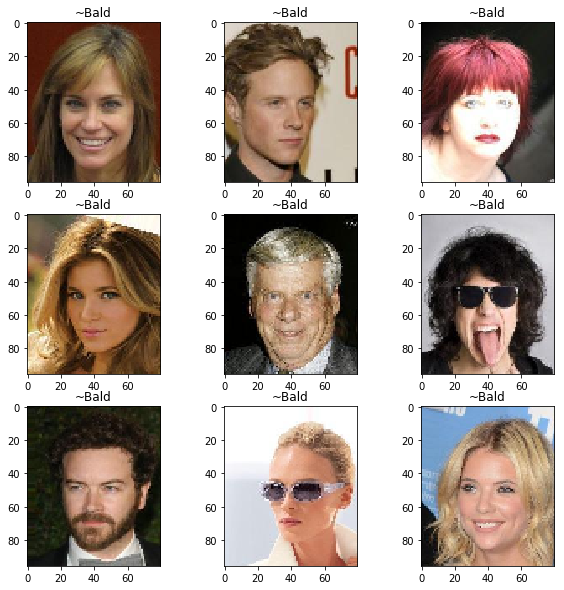

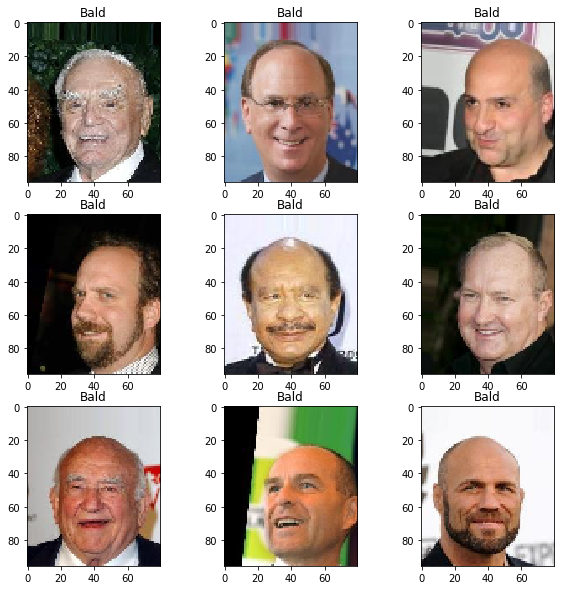

In [15]:
%matplotlib inline
plt.figure(figsize=(10,10))
for i in range(1,10):
    plt.subplot(3,3,i)
    plt.title(examined_feature if labels[i]==1 else '~'+examined_feature)
    plt.imshow(np.squeeze(images[i]))
plt.show()
plt.figure(figsize=(10,10))
for i in range(1,10):
    plt.subplot(3,3,i)
    plt.title(examined_feature if labels[len(labels) - i]==1 else '~'+examined_feature)
    plt.imshow(np.squeeze(images[len(labels) - i]))
plt.show()

## Podział danych na treningowe i testowe

In [16]:
X_train, X_test, y_train, y_test = train_test_split(images.astype('float32')/255, labels, test_size=0.2)

### Standaryzacja danych

In [17]:
X_mean = []
X_std = []
for i in range(3):
    X_mean.append(np.mean(X_train[:,:,:,i]))
    X_std.append(np.std(X_train[:,:,:,i]))
    
    X_train[:,:,:,i] = (X_train[:,:,:,i] - X_mean[-1])/X_std[-1]
    X_test[:,:,:,i] = (X_test[:,:,:,i] - X_mean[-1])/X_std[-1]

## Stworzenie modelu

### Zdefiniowanie parametrów określających architekturę modelu

In [18]:
input_shape = images.shape[1:4] #wielkość obrazu wejściowego, wykorzystywana dla budowy grafu SN

### Zdefiniowanie parametrów definujących trening SN

In [19]:
batch_size = 128 #liczba obrazów wykorzystywana do jednego kroku treningu SN
optimizer = 'adam' #funkcja odpowiadająca za redukcję błędu sieci
loss_fn = 'sparse_categorical_crossentropy' #funkcja służąca do obliczenia o ile różni się wartość oczekiwana od otrzymanej na wyjściu SN
epochs = 30 #maksymalna liczba epok, czyli ile razy sieć będzie widziała dane treningowe
model_path = os.path.join(model_dir,'celeb_cnn_v1_'+examined_feature+'.h5')

### Budowa architektury CNN

In [20]:
inputs = Input(shape=input_shape, name='input')

x = Conv2D(64, (3, 3), activation='relu')(inputs)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)

x = Conv2D(128, (3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)

x = Conv2D(256, (3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)

x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(2, activation='softmax')(x)

model = Model(inputs=inputs, outputs=x, name='CNN')
model.compile(optimizer=optimizer, loss=loss_fn, metrics=['acc'])

### Wprowadzenie funkcji zwrotnych (ang. callback)

Umożliwią nam one dodatkową interakcję z modelem podczas treningu
* zatrzymanie trningu SN jeśli nie ma zauważalnej poprawy funkcji straty dla zbioru walidacyjnego po 3 epokach

In [21]:
early_stop = EarlyStopping(restore_best_weights = True, patience = 3)

* tworzenie punktów kontrolnych w postaci zapisanego modelu po każdej epoce

In [22]:
checkpt = ModelCheckpoint(model_path,save_best_only=True,save_weights_only=True)

### trening SN

In [23]:
history = model.fit(X_train, y_train,
                  epochs=epochs,
                  batch_size=batch_size,
                  validation_data=(X_test, y_test),
                  verbose=2,
                  callbacks = [early_stop, checkpt])

Train on 7275 samples, validate on 1819 samples
Epoch 1/30
 - 17s - loss: 0.6325 - acc: 0.7447 - val_loss: 0.2944 - val_acc: 0.8895
Epoch 2/30
 - 11s - loss: 0.2525 - acc: 0.9061 - val_loss: 0.2088 - val_acc: 0.9236
Epoch 3/30
 - 11s - loss: 0.1904 - acc: 0.9281 - val_loss: 0.1936 - val_acc: 0.9241
Epoch 4/30
 - 11s - loss: 0.1749 - acc: 0.9375 - val_loss: 0.1598 - val_acc: 0.9434
Epoch 5/30
 - 11s - loss: 0.1612 - acc: 0.9419 - val_loss: 0.1651 - val_acc: 0.9434
Epoch 6/30
 - 11s - loss: 0.1446 - acc: 0.9490 - val_loss: 0.1275 - val_acc: 0.9560
Epoch 7/30
 - 11s - loss: 0.1326 - acc: 0.9515 - val_loss: 0.1626 - val_acc: 0.9373
Epoch 8/30
 - 11s - loss: 0.1305 - acc: 0.9549 - val_loss: 0.1208 - val_acc: 0.9555
Epoch 9/30
 - 11s - loss: 0.1215 - acc: 0.9556 - val_loss: 0.1239 - val_acc: 0.9538
Epoch 10/30
 - 11s - loss: 0.1229 - acc: 0.9548 - val_loss: 0.1367 - val_acc: 0.9494
Epoch 11/30
 - 11s - loss: 0.1091 - acc: 0.9619 - val_loss: 0.1274 - val_acc: 0.9549


In [24]:
model.load_weights(model_path)

## Weryfikacja jakości predykkcji

In [25]:
y_pred = np.argmax(model.predict(X_test),axis=-1)

In [26]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

      False       0.97      0.94      0.95       901
       True       0.94      0.97      0.96       918

avg / total       0.96      0.96      0.96      1819



## Wizualizacja CAM

In [27]:
model_vis = model
model_vis.layers[-1].activation = activations.linear
model_vis = utils.apply_modifications(model_vis)

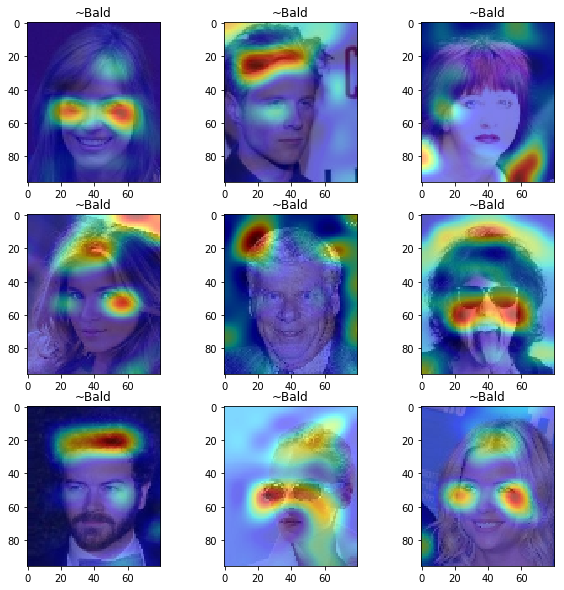

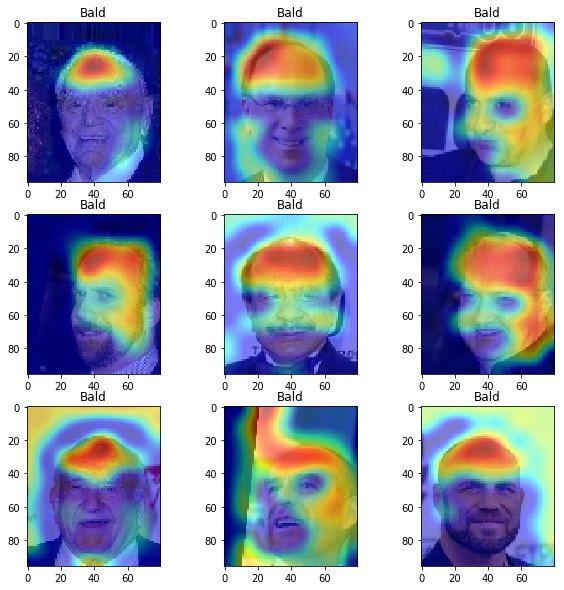

In [28]:
%matplotlib inline
plt.figure(figsize=(10,10))
for i in range(1,10):
    plt.subplot(3,3,i)
    plt.title(examined_feature if labels[i]==1 else '~'+examined_feature)
    grads = visualize_cam(model_vis, -1, filter_indices=int(labels[i]), 
                          seed_input=images[i], backprop_modifier='guided')    
    plt.imshow(overlay(cm.jet(grads)[:,:,:3], images[i]/255))
plt.show()

plt.figure(figsize=(10,10))
for i in range(1,10):
    plt.subplot(3,3,i)
    plt.title(examined_feature if labels[len(labels) - i]==1 else '~'+examined_feature)
    grads = visualize_cam(model_vis, -1, filter_indices=int(labels[[len(labels) - i]]), 
                          seed_input=images[len(labels) - i], backprop_modifier='guided')    
    plt.imshow(overlay(cm.jet(grads)[:,:,:3], images[len(labels) - i]/255))
plt.show()

## Zobaczmy jak to działa na zdjęciu z internetu

* Przykład 1

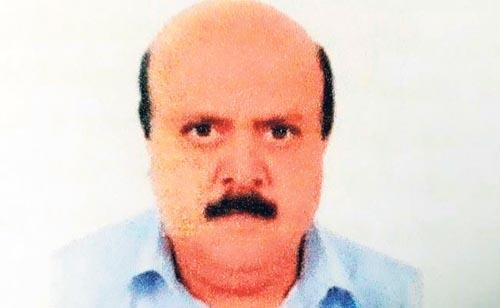

In [29]:
from urllib.request import urlopen
from resizeimage import resizeimage

img = Image.open(urlopen('http://www.afternoondc.in/Thumbnails.aspx?Filename=2018319214726.jpg'))
img

In [30]:
img.size

(500, 308)

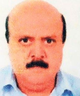

In [31]:
img = resizeimage.resize_cover(img, [80, 96])
img

In [32]:
img_float = np.array(img).astype(np.float32)
img_std = img_float.copy()
for i in range(3):
    img_std[:,:,i] = (img_std[:,:,i]-X_mean[i])/X_std[i]
img_std = np.expand_dims(img_std,0)
img_std.shape

(1, 96, 80, 3)

In [33]:
img_pred = model.predict(img_std)
img_pred

array([[0., 1.]], dtype=float32)

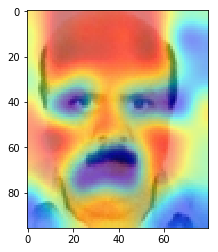

In [34]:
grads = visualize_cam(model_vis, -1, filter_indices=1, 
                      seed_input=np.squeeze(img_std), backprop_modifier='guided')    
plt.imshow(overlay(cm.jet(grads)[:,:,:3], img_float/255))
plt.show()

* Przykład 2 - spróbuj sam/-a

In [ ]:
from urllib.request import urlopen
from resizeimage import resizeimage

img = Image.open(urlopen(' tutaj link do obrazka '))
img

In [ ]:
img.size

In [ ]:
img = resizeimage.resize_cover(img, [80, 96])
img

In [ ]:
img_float = np.array(img).astype(np.float32)
img_std = img_float.copy()
for i in range(3):
    img_std[:,:,i] = (img_std[:,:,i]-X_mean[i])/X_std[i]
img_std = np.expand_dims(img_std,0)
img_std.shape

In [ ]:
img_pred = model.predict(img_std)
img_pred

In [ ]:
grads = visualize_cam(model_vis, -1, filter_indices=1, 
                      seed_input=np.squeeze(img_std), backprop_modifier='guided')    
plt.imshow(overlay(cm.jet(grads)[:,:,:3], img_float/255))
plt.show()